In [1]:
import os

import tqdm
import torch
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn

import vari
import vari.datasets
import vari.models
import vari.inference
from vari.layers import GaussianSample, BernoulliSample

from sklearn.datasets import make_circles

In [2]:
experiments_dir = '/nas/experiments/sacred/models/'
data_root = '/home/jdh/repos/vari/torch_data'
mpl.style.use('default')

## Select models and data

In [19]:
run_ids_all_labels = dict(
    MNISTBinarized=dict(
        vae=6237,
        hvae=None,
        avae=None
    ),
    FashionMNISTBinarized=dict(
        vae=6241,
        hvae=None,
        avae=None
    )
)

run_ids_excluded_labels = dict(
    MNISTBinarized=dict(
        vae={'4': None, '8': None},
        hvae={'4': None, '8': None},
        avae={'4': None, '8': None}
    ),
    FashionMNISTBinarized=dict(
        vae={'4': None, '8': None},
        hvae={'4': None, '8': None},
        avae={'4': None, '8': None}
    )
)

#run_ids = dict(
#    vae=6209,
#    hvae=6203,
##    avae=6219,
#)

#dataset_name = 'spirals'
#run_ids = dict(
#    vae=6211,
#    avae=6220,
#    hvae=6205,
#)

## Get datasets

In [4]:
mnist_train = vari.datasets.MNISTBinarized(split='train', preprocess='static', exclude_labels=[], root=data_root)
mnist_test1 = vari.datasets.MNISTBinarized(split='test', preprocess='static', exclude_labels=[], root=data_root)

In [5]:
fashion_mnist_train = vari.datasets.FashionMNISTBinarized(split='train', preprocess='static', exclude_labels=[], root=data_root)
fashion_mnist_test1 = vari.datasets.FashionMNISTBinarized(split='test', preprocess='static', exclude_labels=[], root=data_root)

### Visualize dataset

In [6]:
def plot_image_matrix(images, ax):
    rows = int(np.sqrt(len(images)))
    cols = rows
    image_rows = [np.concatenate(images[i:i+cols], axis=1) for i in range(rows)]
    image_matrix = np.concatenate(image_rows, axis=0)
    ax.imshow(image_matrix, cmap='binary_r')
    ax.axis('off')

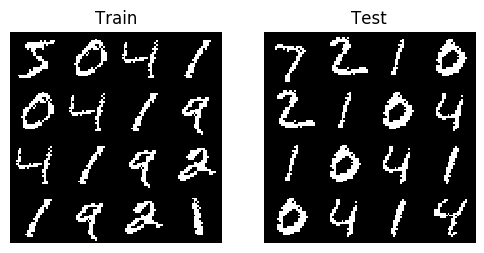

In [7]:
start_idx = 0
n_images = 4 * 4
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 12))
plot_image_matrix(mnist_train.examples[start_idx: start_idx + n_images], ax1)
plot_image_matrix(mnist_test1.examples[start_idx: start_idx + n_images], ax2)
ax1.set_title('Train')
ax2.set_title('Test');

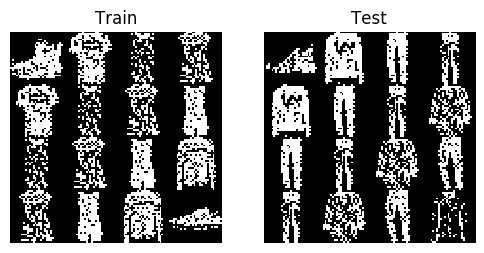

In [8]:
start_idx = 0
n_images = 4 * 4
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 12))
plot_image_matrix(fashion_mnist_train.examples[start_idx: start_idx + n_images], ax1)
plot_image_matrix(fashion_mnist_test1.examples[start_idx: start_idx + n_images], ax2)
ax1.set_title('Train')
ax2.set_title('Test');

## Load models trained on all labels

In [15]:
def get_data(train_data):
    if train_data == 'MNISTBinarized':
        x_train = mnist_train.examples.reshape(-1, 784)
        x_test1 = mnist_test1.examples.reshape(-1, 784)
        x_test2 = fashion_mnist_test1.examples.reshape(-1, 784)
        y_train = mnist_train.labels.argmax(axis=1)
        y_test1 = mnist_test1.labels.argmax(axis=1)
        y_test2 = fashion_mnist_test1.labels.argmax(axis=1)
    elif train_data == 'FashionMNISTBinarized':
        x_train = fashion_mnist_train.examples.reshape(-1, 784)
        x_test1 = fashion_mnist_test1.examples.reshape(-1, 784)
        x_test2 = mnist_test1.examples.reshape(-1, 784)
        y_train = fashion_mnist_train.labels.argmax(axis=1)
        y_test1 = fashion_mnist_test1.labels.argmax(axis=1)
        y_test2 = mnist_test1.labels.argmax(axis=1)
    return x_train, x_test1, x_test2, y_train, y_test1, y_test2

In [16]:
def load_models(run_ids):
    latent_space_models = dict()
    for model_abbr, model_name in [('vae', 'VariationalAutoencoder'),
                                   ('avae', 'AuxilliaryVariationalAutoencoder'),
                                   ('hvae', 'HierarchicalVariationalAutoencoder')]:
        try:
            run_id = str(run_ids[model_abbr])
            kwargs = vari.models.get_default_model_config(model_name, train_data)
            
            model = getattr(vari.models.vae, model_name)
            model = model(x_dim=784, **kwargs)
            model.load_state_dict(torch.load(
                os.path.join(experiments_dir, run_id, 'model_state_dict.pkl'),
                map_location=torch.device('cpu')
            ))
            
            latent_space_models[model_abbr] = model

        except Exception as exc:
            print(model_abbr, exc)
    return latent_space_models

In [17]:
train_data = 'MNISTBinarized'
train_data = 'FashionMNISTBinarized'
x_train, x_test1, x_test2, y_train, y_test1, y_test2 = get_data(train_data)

In [20]:
latent_space_models = load_models(run_ids_all_labels[train_data])

avae [Errno 2] No such file or directory: '/nas/experiments/sacred/models/None/model_state_dict.pkl'
hvae [Errno 2] No such file or directory: '/nas/experiments/sacred/models/None/model_state_dict.pkl'


## Visualize latent space

In [21]:
def plot_vectors(vectors, fig=None, ax=None, figsize=(20, 20), color='C0', alpha=0.4, label='train', label_ids=None):
    if ax is None:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(1, 1, 1)
        
    if label_ids is not None:
        for i in np.unique(label_ids):
            ax.scatter(vectors[label_ids==i, 0],
                       vectors[label_ids==i, 1],
                       s=2.5, c=f'C{i}', alpha=alpha, label=f"{label}:class{i}")
    else:
        ax.scatter(vectors[:,0], vectors[:,1], c=color, alpha=alpha, label=label)
    #ax1.scatter(vae_qz_mu_x2[:,0], vae_qz_mu_x2[:,1], c=[test1_0], alpha=0.4, label="test1")
    #ax.plot(mesh[:,0], mesh[:,1], c='black', alpha=.2, linewidth=.5)
    #ax.scatter(mesh[:,0], mesh[:,1], c=[(.8, .8, .8, .8)], alpha=.5, s=5.)
    # ax1.axis('off')
    ax.legend()
    return fig, ax

### VAE

In [22]:
vae = latent_space_models['vae']
with torch.no_grad():
    vae_qz_x_train, (vae_qz_mu_x_train, vae_qz_log_var_x_train) = vae.encode(torch.FloatTensor(x_train))
    vae_qz_x_test1, (vae_qz_mu_x_test1, vae_qz_log_var_x_test1) = vae.encode(torch.FloatTensor(x_test1))
    vae_qz_x_test2, (vae_qz_mu_x_test2, vae_qz_log_var_x_test2) = vae.encode(torch.FloatTensor(x_test2))

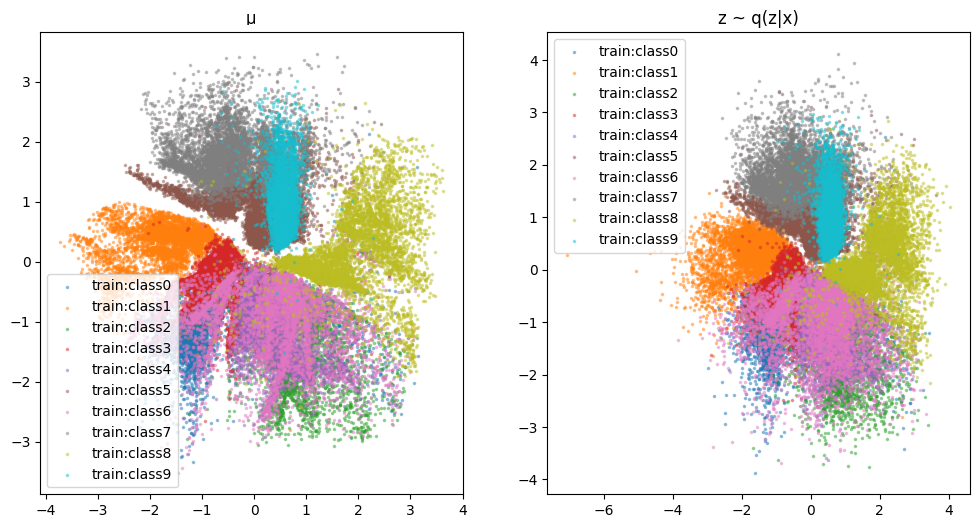

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
plot_vectors(vae_qz_mu_x_train, label_ids=y_train, ax=ax1)
plot_vectors(vae_qz_x_train, label_ids=y_train, ax=ax2)
ax1.set_title('µ')
ax2.set_title('z ~ q(z|x)')
plt.show()

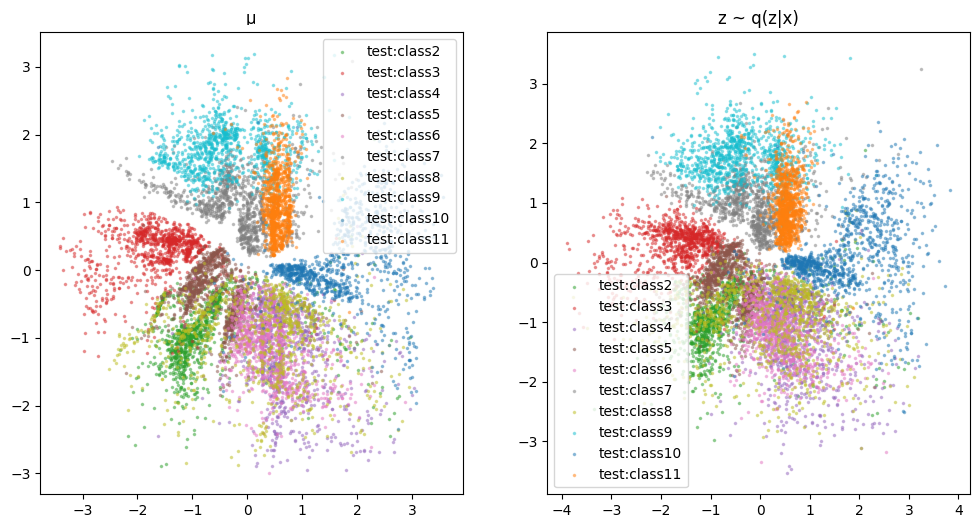

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
plot_vectors(vae_qz_mu_x_test1, label_ids=y_test1+2, ax=ax1, label='test')
plot_vectors(vae_qz_x_test1, label_ids=y_test1+2, ax=ax2, label='test')
ax1.set_title('µ')
ax2.set_title('z ~ q(z|x)')
plt.show()

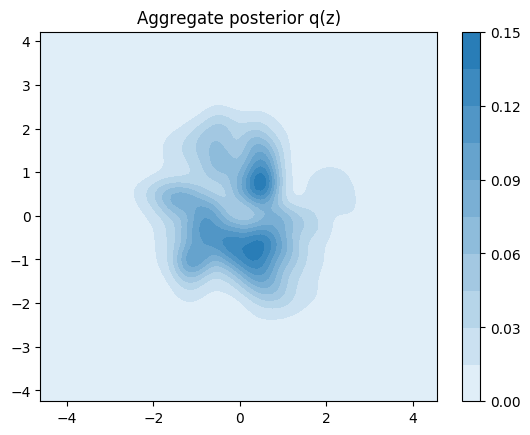

In [25]:
fig, ax1 = plt.subplots(1, 1)
ax1.set_title('Aggregate posterior q(z)')
seaborn.kdeplot(vae_qz_x_test1[:, 0].numpy(),
                data2=vae_qz_x_test1[:, 1].numpy(),
                shade=True,
                cbar=True,
                ax=ax1)

### AVAE

In [22]:
avae = latent_space_models['avae']
with torch.no_grad():
    (avae_qz_x_train, (avae_qz_mu_x_train, avae_qz_log_var_x_train)), (avae_qa_x_train, (avae_qa_mu_x_train, avae_qa_log_var_x_train)) = avae.encode(torch.FloatTensor(x_train))
    (avae_qz_x_test1, (avae_qz_mu_x_test1, avae_qz_log_var_x_test1)), (avae_qa_x_test1, (avae_qa_mu_x_test1, avae_qa_log_var_x_test1)) = avae.encode(torch.FloatTensor(x_test1))
    (avae_qz_mesh, (avae_qz_mu_mesh, avae_qz_log_var_mesh)), (avae_qa_mesh, (avae_qa_mu_mesh, avae_qa_log_var_mesh)) = avae.encode(torch.FloatTensor(x_train_meshgrid))

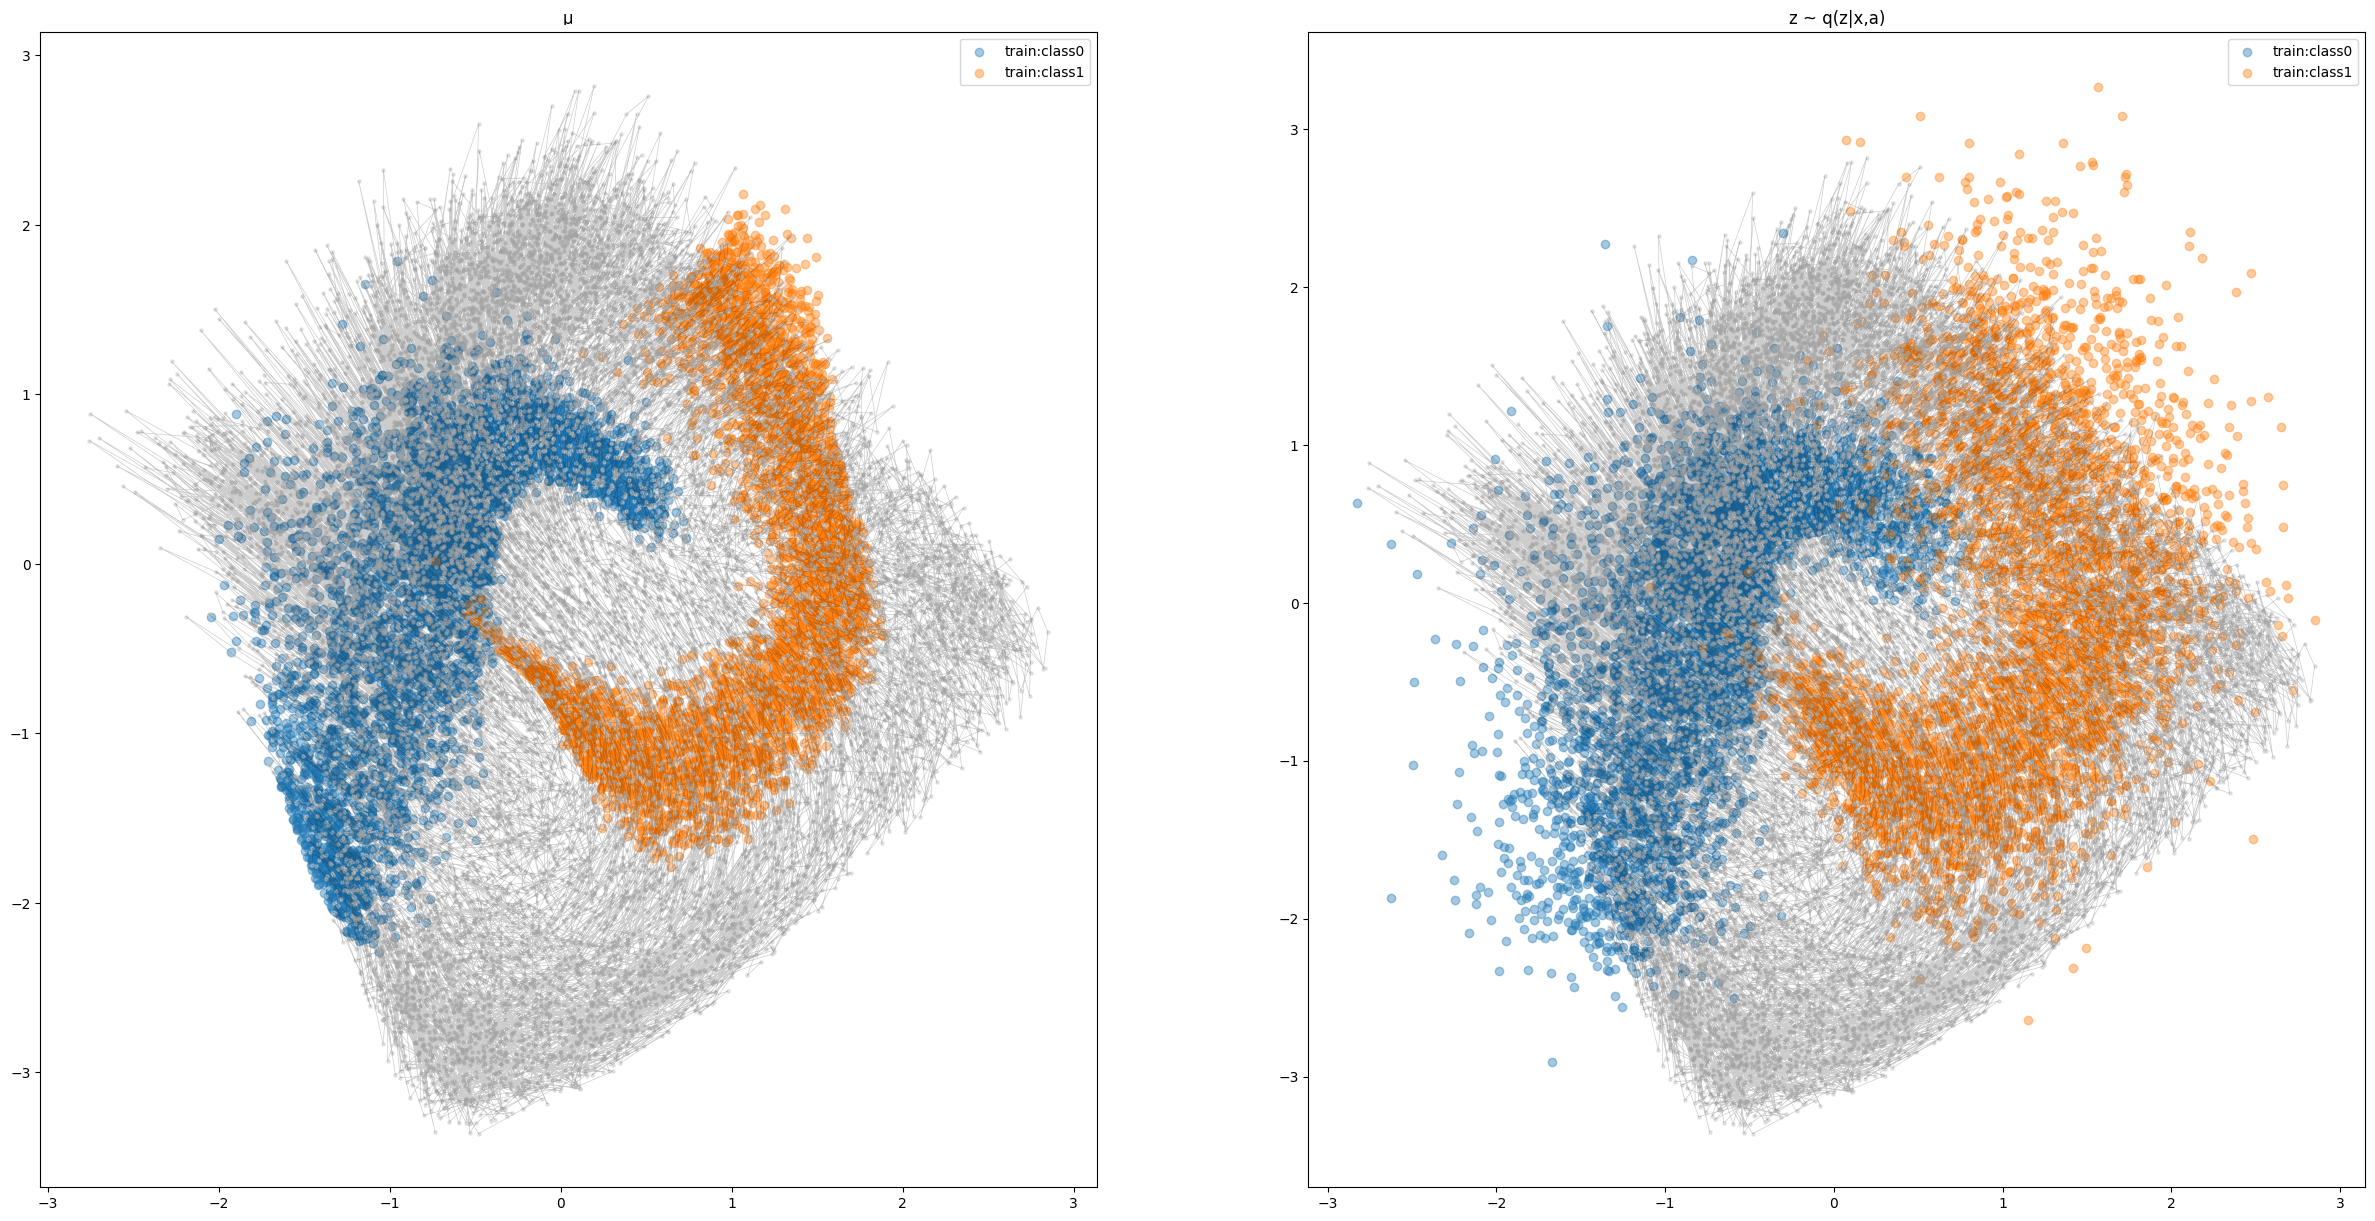

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
plot_vectors_and_mesh(avae_qz_mu_x_train, avae_qz_mu_mesh, label_ids=y_train, ax=ax1)
plot_vectors_and_mesh(avae_qz_x_train, avae_qz_mu_mesh, label_ids=y_train, ax=ax2)
ax1.set_title('µ')
ax2.set_title('z ~ q(z|x,a)')
plt.show()

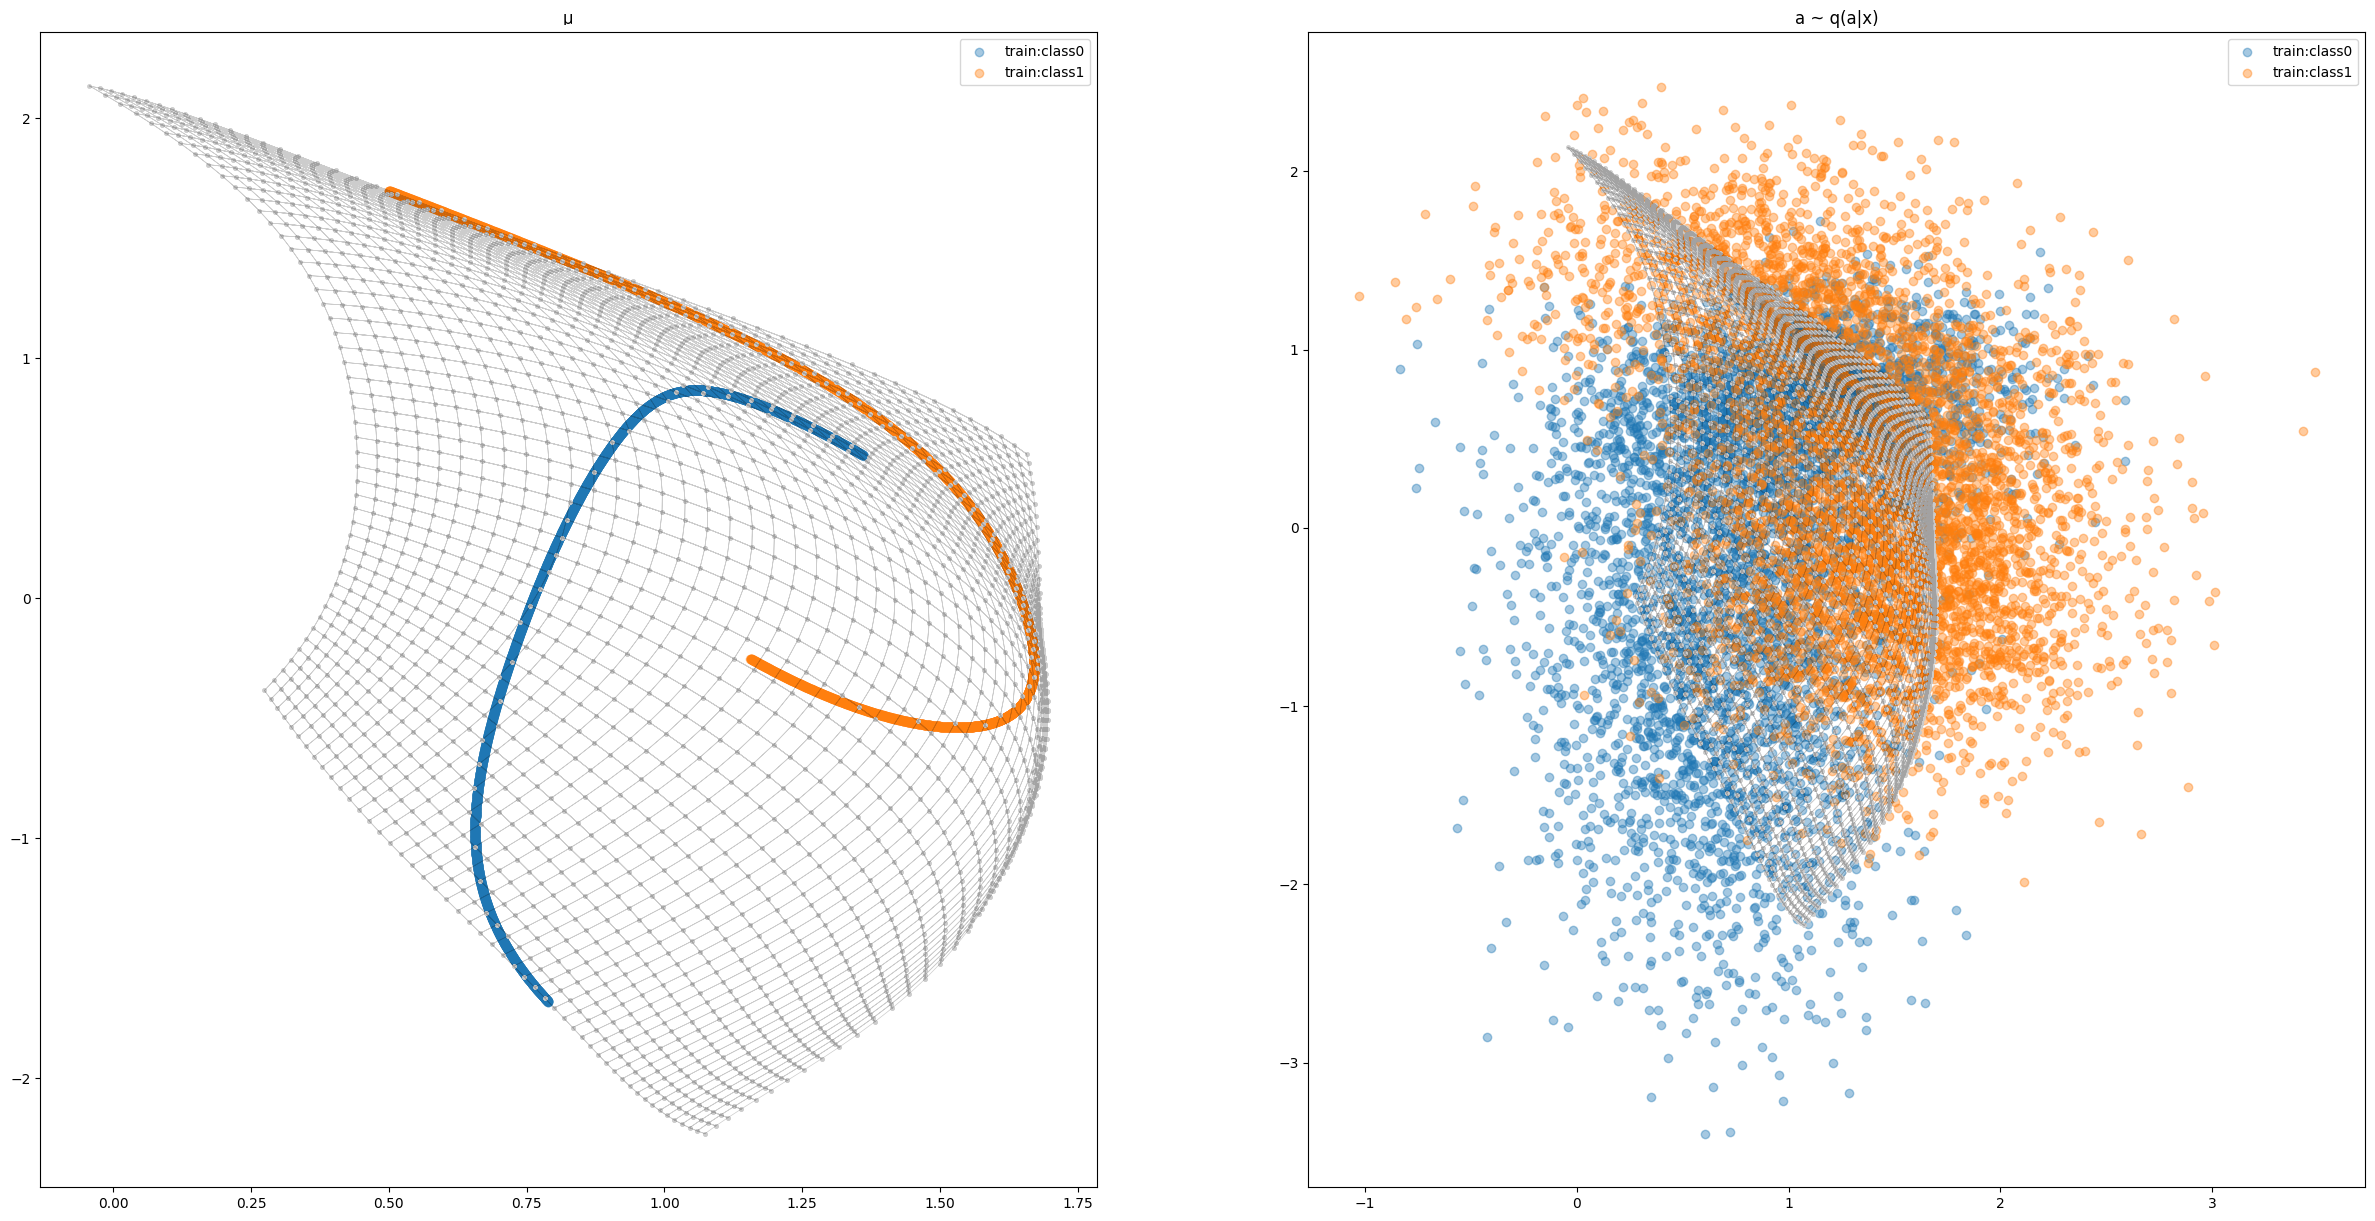

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
plot_vectors_and_mesh(avae_qa_mu_x_train, avae_qa_mu_mesh, label_ids=y_train, ax=ax1)
plot_vectors_and_mesh(avae_qa_x_train, avae_qa_mu_mesh, label_ids=y_train, ax=ax2)
ax1.set_title('µ')
ax2.set_title('a ~ q(a|x)')
plt.show()

In [ ]:
fig, ax1 = plt.subplots(1, 1)
ax1.set_title('Aggregate posterior q(z)')
seaborn.kdeplot(avae_qz_x_test1[:, 0].numpy(),
                data2=vae_qz_x_test1[:, 1].numpy(),
                shade=True,
                cbar=True,
                ax=ax1)

### HVAE

In [156]:
hvae = latent_space_models['hvae']
with torch.no_grad():
    latents_train = hvae.encode(torch.FloatTensor(x_train))
    latents_test1 = hvae.encode(torch.FloatTensor(x_test1))
    latents_test2 = hvae.encode(torch.FloatTensor(x_test2))

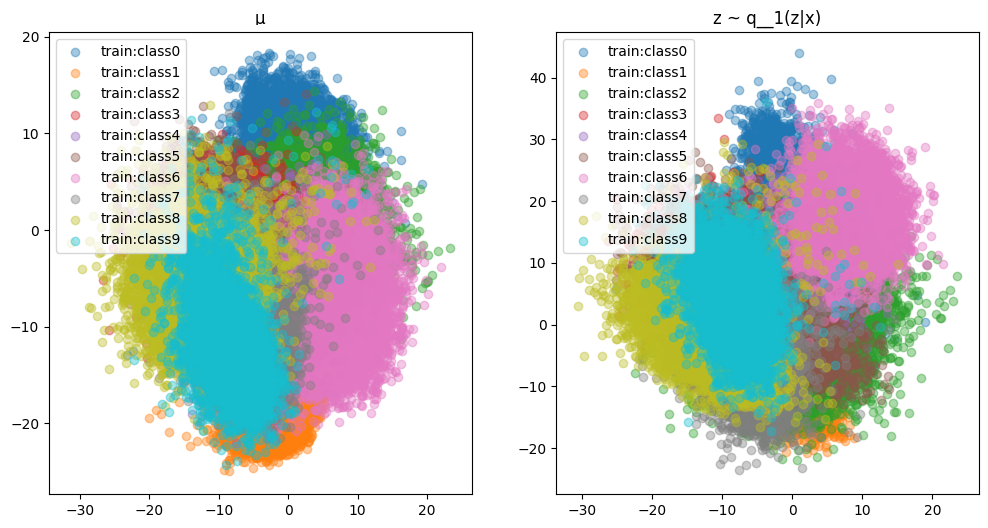

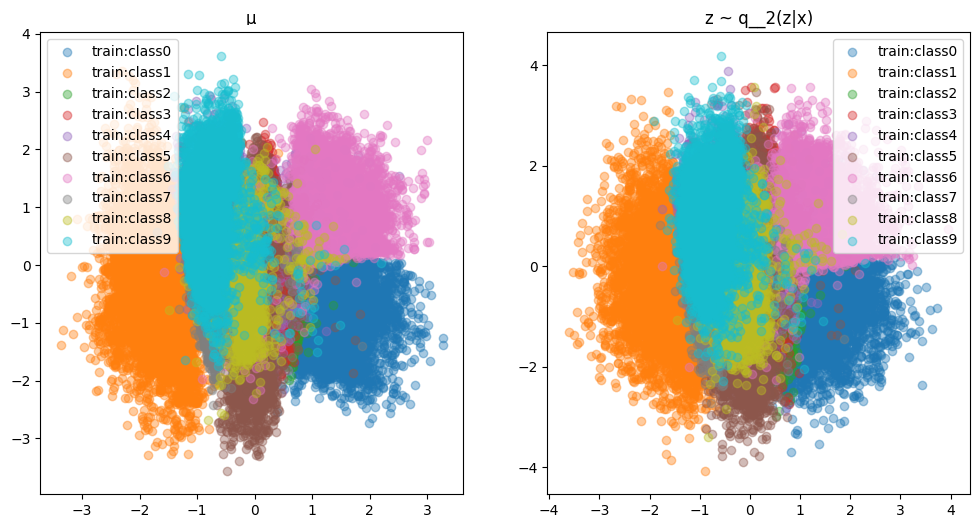

In [157]:
non_2d_elements = [0, 3]
for i_layer in range(len(latents_train)):
    hvae_qz_x_train = latents_train[i_layer][0]
    hvae_qz_mu_x_train = latents_train[i_layer][1][0]
    
    if hvae_qz_x_train.shape[1] > 2:
        hvae_qz_x_train = hvae_qz_x_train[:, non_2d_elements]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    plot_vectors(hvae_qz_mu_x_train, label_ids=y_train, ax=ax1)
    plot_vectors(hvae_qz_x_train, label_ids=y_train, ax=ax2)
    ax1.set_title('µ')
    ax2.set_title(f'z ~ q__{i_layer+1}(z|x)')
    plt.show()

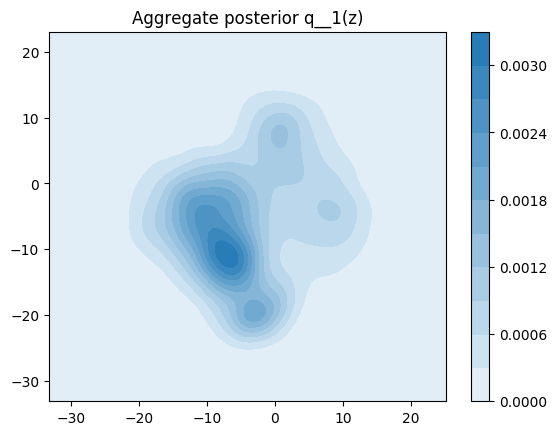

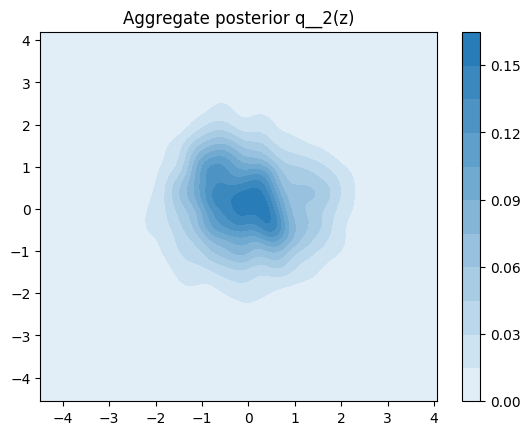

In [158]:
for i_layer in range(len(latents_test1)):
    hvae_qz_x_test1 = latents_test1[i_layer][0]
    hvae_qz_mu_x_test1 = latents_test1[i_layer][1][0]
    
    fig, ax1 = plt.subplots(1, 1)
    ax1.set_title(f'Aggregate posterior q__{i_layer+1}(z)')
    seaborn.kdeplot(hvae_qz_x_test1[:, 0].numpy(),
                    data2=hvae_qz_x_test1[:, 1].numpy(),
                    shade=True,
                    cbar=True,
                    ax=ax1)

## Visualize reconstruction

In [35]:
n_samples = 10*10
x_originals = torch.FloatTensor(x_test1[:n_samples])
with torch.no_grad():
    vae_p_x_reconstructions, vae_p_x_parameters = vae(x_originals)
    hvae_p_x_reconstructions, vae_p_x_parameters = hvae(x_originals)
    avae_p_x_reconstructions, vae_p_x_parameters = avae(x_originals)

NameError: name 'hvae' is not defined

In [ ]:
def plot_image_matrix(images, ax):
    rows = int(np.sqrt(len(images)))
    cols = rows
    image_rows = [np.concatenate(images[i:i+cols], axis=1) for i in range(rows)]
    image_matrix = np.concatenate(image_rows, axis=0)
    ax.imshow(image_matrix, cmap='binary_r')
    ax.axis('off')

In [39]:
vae_p_x_reconstructions

tensor([[7.2381e-09, 3.2808e-06, 4.7538e-06,  ..., 6.9173e-08, 2.4927e-07,
         1.4378e-06],
        [8.7602e-08, 2.6153e-07, 9.5548e-06,  ..., 6.1202e-03, 7.8276e-05,
         1.1338e-05],
        [4.4711e-08, 4.3665e-07, 7.5557e-07,  ..., 5.3330e-06, 1.1634e-05,
         1.1874e-05],
        ...,
        [1.7811e-09, 1.0332e-07, 5.1383e-07,  ..., 5.1828e-06, 2.9452e-06,
         1.7921e-06],
        [2.7057e-07, 1.3190e-06, 9.6971e-05,  ..., 6.5683e-03, 1.5104e-04,
         2.3581e-05],
        [1.7364e-07, 4.6441e-07, 2.5654e-05,  ..., 2.0186e-02, 5.2183e-05,
         1.0576e-05]])

In [45]:
vae_p_x_reconstructions = vae_p_x_reconstructions.reshape(vae_p_x_reconstructions.shape[0], 28, 28)

TypeError: The first input argument needs to be a sequence

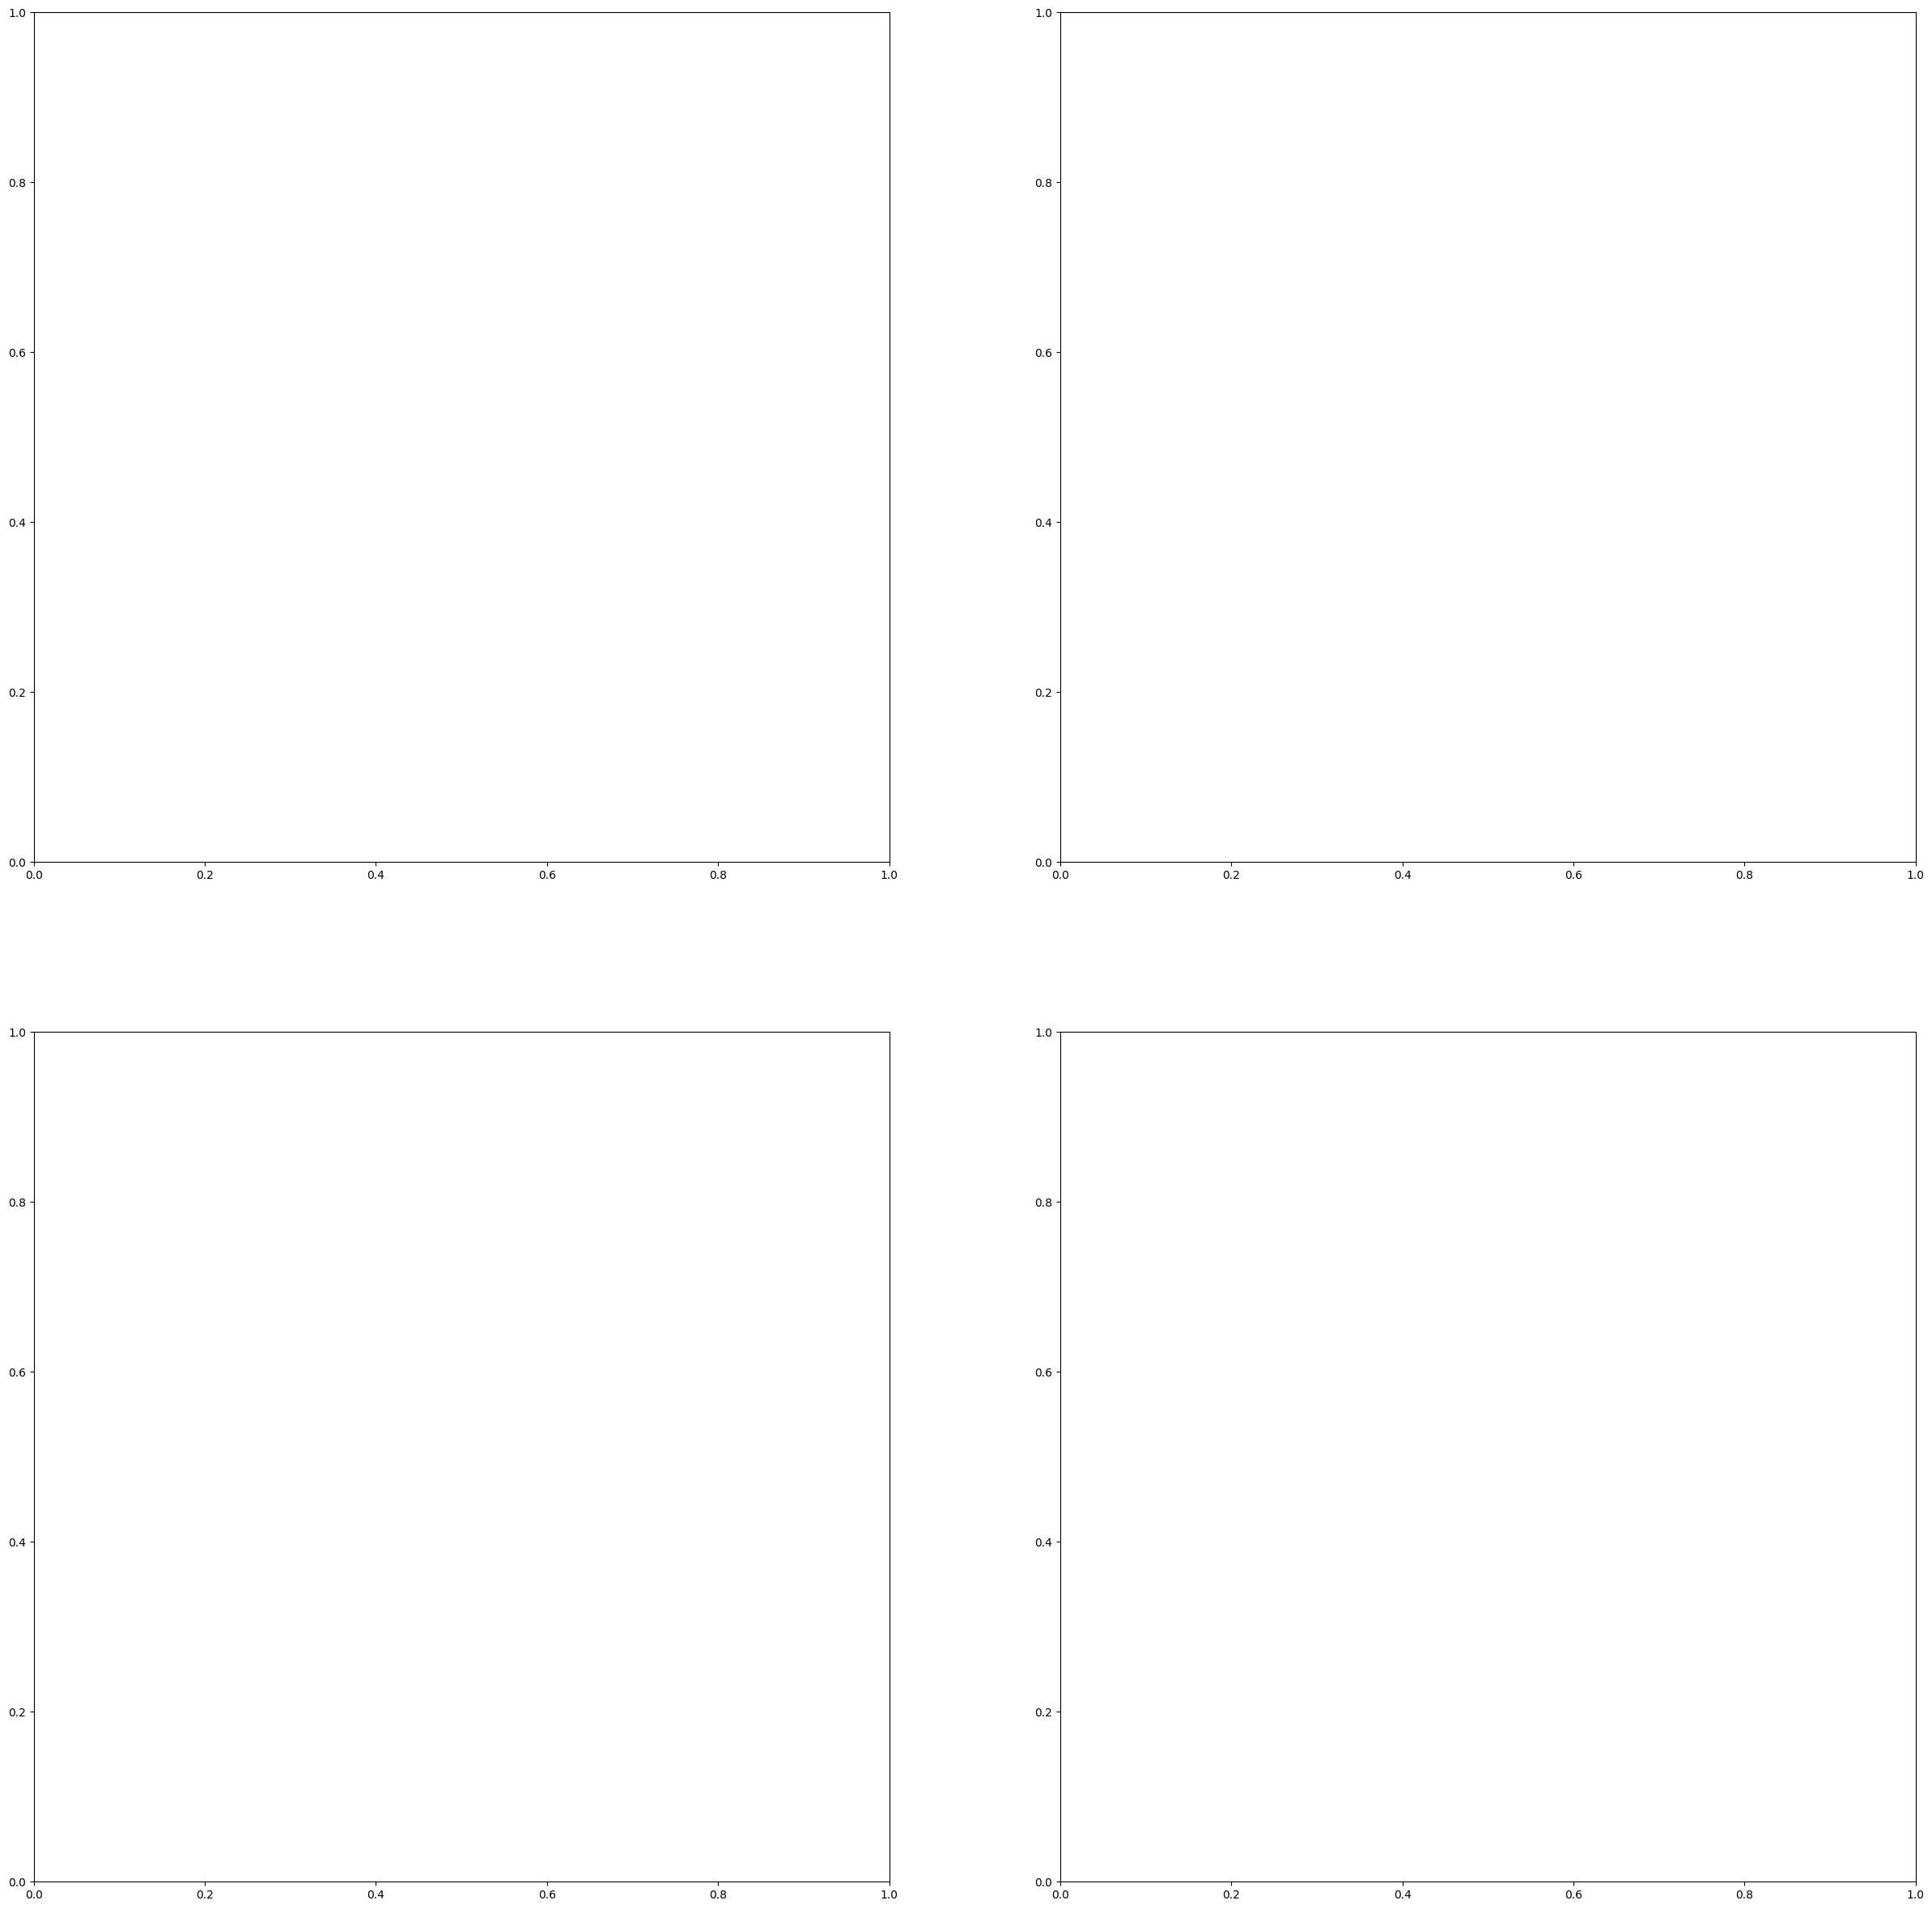

In [46]:
fig, axes = plt.subplots(2, 2, figsize=(30, 30))
ax1, ax2, ax3, ax4 = [ax for ax_row in axes for ax in ax_row]
plot_image_matrix(vae_p_x_reconstructions, ax1)

NameError: name 'avae_p_x_reconstructions' is not defined

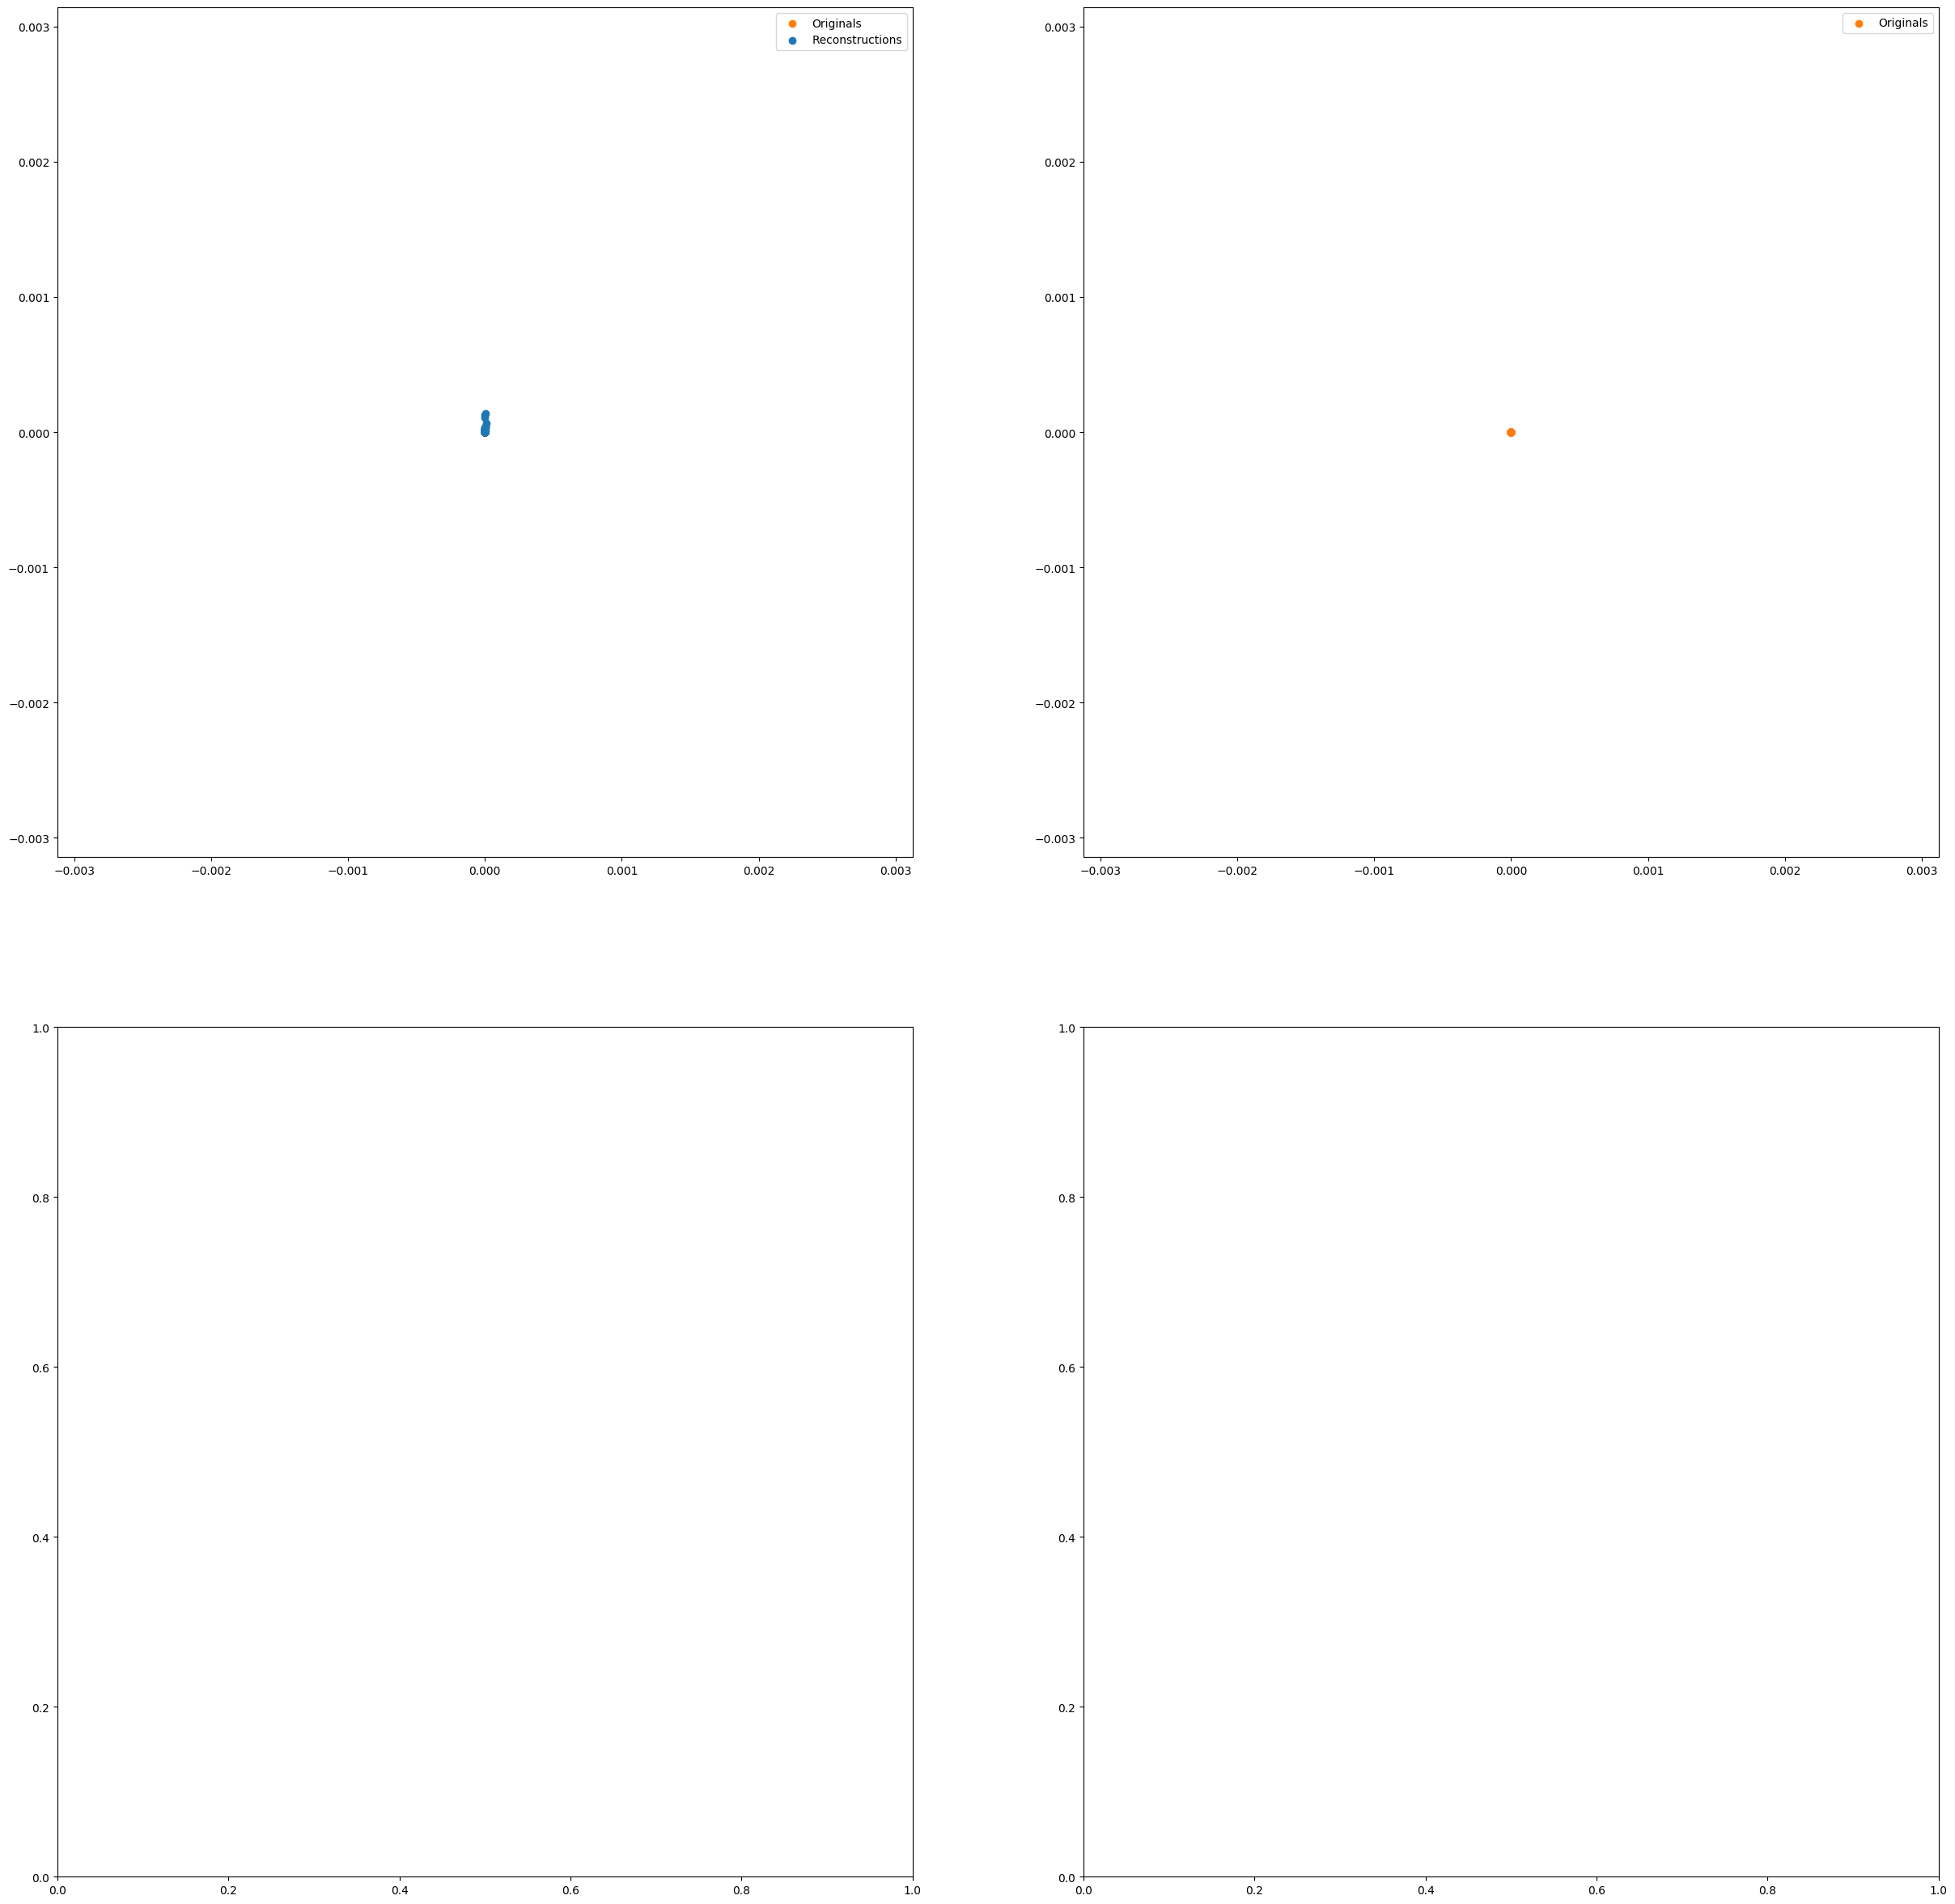

In [38]:
fig, axes = plt.subplots(2, 2, figsize=(30, 30))
ax1, ax2, ax3, ax4 = [ax for ax_row in axes for ax in ax_row ]
plot_vectors(x_originals, alpha=1, color='C1', label='Originals', ax=ax1)
plot_vectors(vae_p_x_reconstructions, alpha=1, label='Reconstructions', ax=ax1)
plot_vectors(x_originals, alpha=1, color='C1', label='Originals', ax=ax2)
plot_vectors(avae_p_x_reconstructions, alpha=1, label='Reconstructions', ax=ax2)
plot_vectors(x_originals, alpha=1, color='C1', label='Originals', ax=ax3)
plot_vectors(hvae_p_x_reconstructions, alpha=1, label='Reconstructions', ax=ax3)
ax1.set_title('VAE')
ax2.set_title('AVAE')
ax3.set_title('HVAE')
plt.show()

## Visualize sampling

In [32]:
n_samples = 10000
p_z_samples = torch.randn((n_samples, 2))

In [34]:
with torch.no_grad():
    vae_p_x_samples, (vae_p_x_mu, vae_p_x_log_var) = vae.sample(p_z_samples)
    avae_p_x_samples, (avae_p_x_mu, avae_p_x_log_var) = avae.sample(p_z_samples)
    hvae_p_x_samples, (hvae_p_x_mu, hvae_p_x_log_var) = hvae.sample(p_z_samples)

NameError: name 'q_z' is not defined

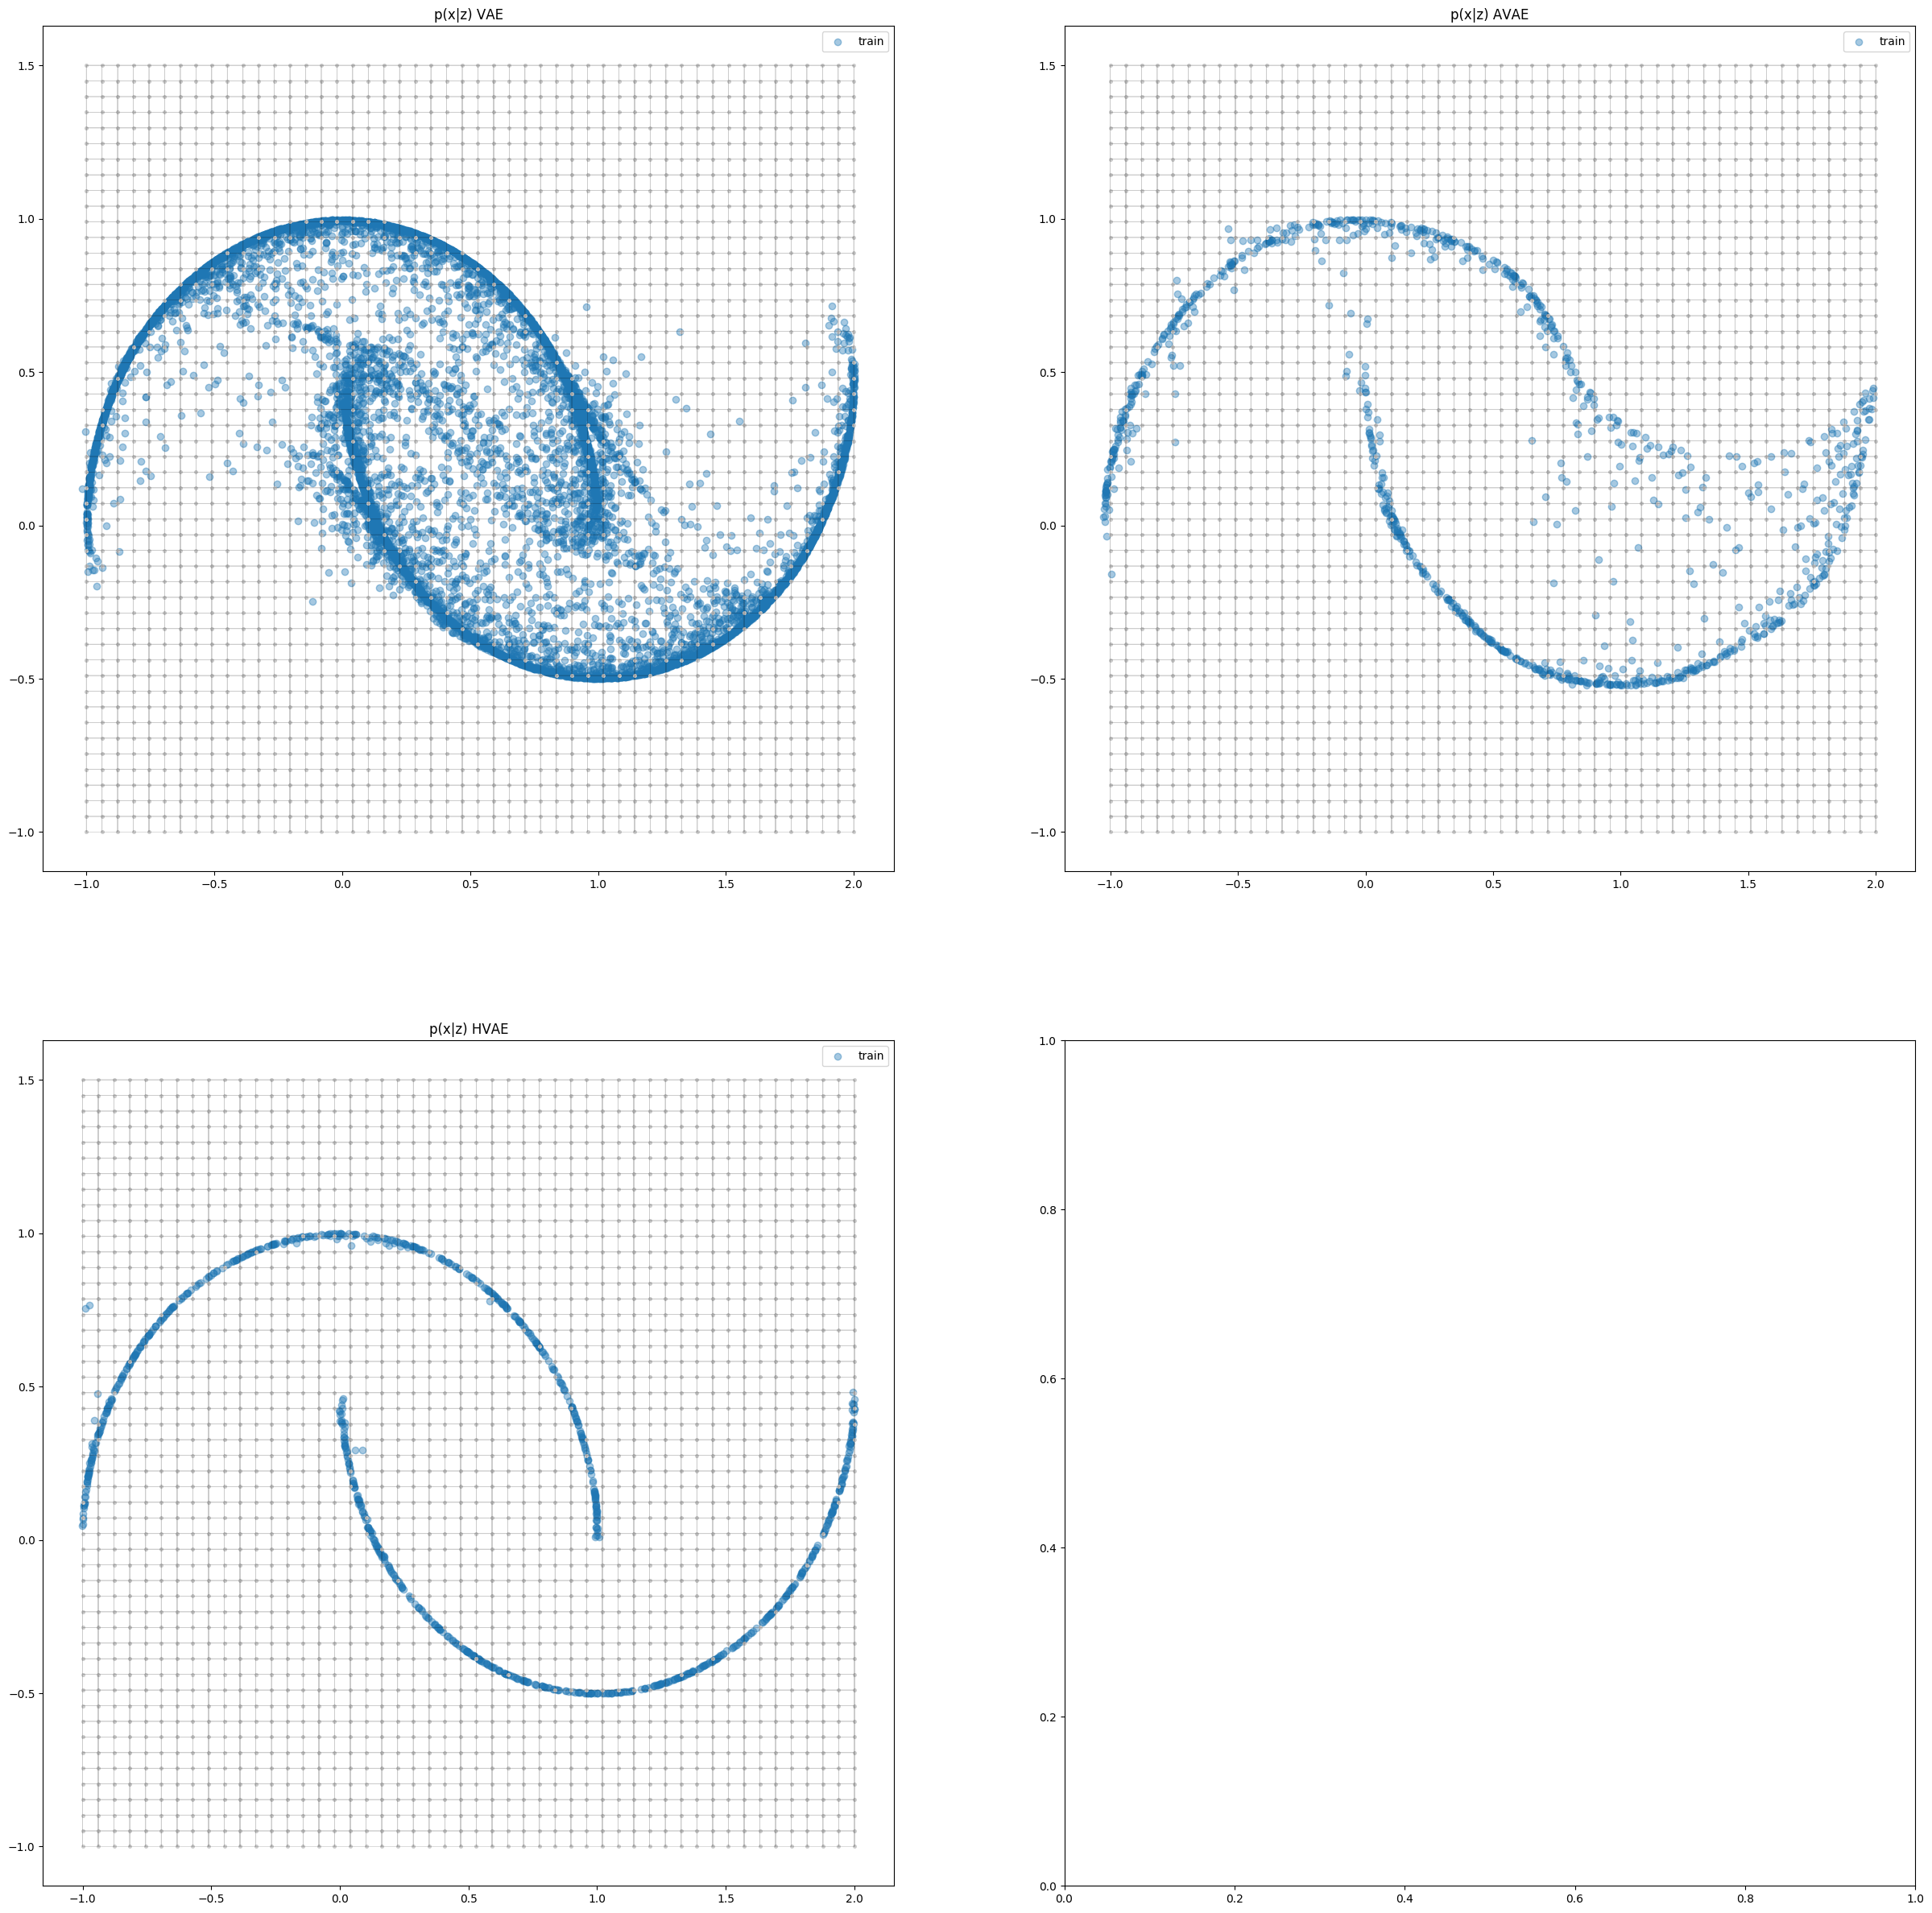

In [35]:
fig, axes = plt.subplots(2, 2, figsize=(30, 30))
ax1, ax2, ax3, ax4 = [ax for ax_row in axes for ax in ax_row ]
plot_vectors_and_mesh(vae_p_x_mu, x_train_meshgrid, ax=ax1)
plot_vectors_and_mesh(avae_p_x_mu, x_train_meshgrid, ax=ax2)
plot_vectors_and_mesh(hvae_p_x_mu, x_train_meshgrid, ax=ax3)
ax1.set_title('p(x|z) VAE')
ax2.set_title('p(x|z) AVAE')
ax3.set_title('p(x|z) HVAE')
plt.show()

## OOD detection based on ELBO

In [ ]:
def compute_elbo_no_iw(model, x):
    with torch.no_grad():
        x = torch.FloatTensor(x)

        px, px_args = model.forward(x)

        kl_divergence = vae.kl_divergence
        likelihood = model.log_likelihood(x, *px_args)
        elbo = likelihood - kl_divergence

        return elbo, kl_divergence, likelihood

def compute_elbo_iw(model, x, importance_samples=1):
    with torch.no_grad():
        x = torch.FloatTensor(x)
        x = x.repeat(1, importance_samples).view(-1, x.shape[1])

        px, px_args = model.forward(x)

        kl_divergence = model.kl_divergence
        likelihood = model.log_likelihood(x, *px_args)
        elbo = likelihood - kl_divergence

        elbo_mean = vari.utilities.log_sum_exp(elbo.view(-1, importance_samples, 1), axis=1, sum_op=torch.mean).view(-1)  # (B, 1, 1)
        lielihood_mean = vari.utilities.log_sum_exp(likelihood.view(-1, importance_samples, 1), axis=1, sum_op=torch.mean).view(-1)  # (B, 1, 1)
        kl_divergence_mean = vari.utilities.log_sum_exp(kl_divergence.view(-1, importance_samples, 1), axis=1, sum_op=torch.mean).view(-1)  # (B, 1, 1)

        return elbo_mean, kl_divergence_mean, lielihood_mean

def compute_elbo(model, x, importance_samples=0):
    if importance_samples == 0:
        return compute_elbo_no_iw(model, x)
    return compute_elbo_iw(model, x, importance_samples)

### OOD between datasets

#### Train on MNIST - Test on FashionMNIST

In [ ]:
x_train, x_test1, x_test2, y_train, y_test1, y_test2 = get_data('MNISTBinarized')


In [137]:
vae_elbo_train, vae_kl_train, vae_likelihood_train = compute_elbo(vae, x_train, importance_samples=10)
vae_elbo_test1, vae_kl_test1, vae_likelihood_test1 = compute_elbo(vae, x_test1, importance_samples=10)
vae_elbo_test2, vae_kl_test2, vae_likelihood_test2 = compute_elbo(vae, x_test2, importance_samples=10)

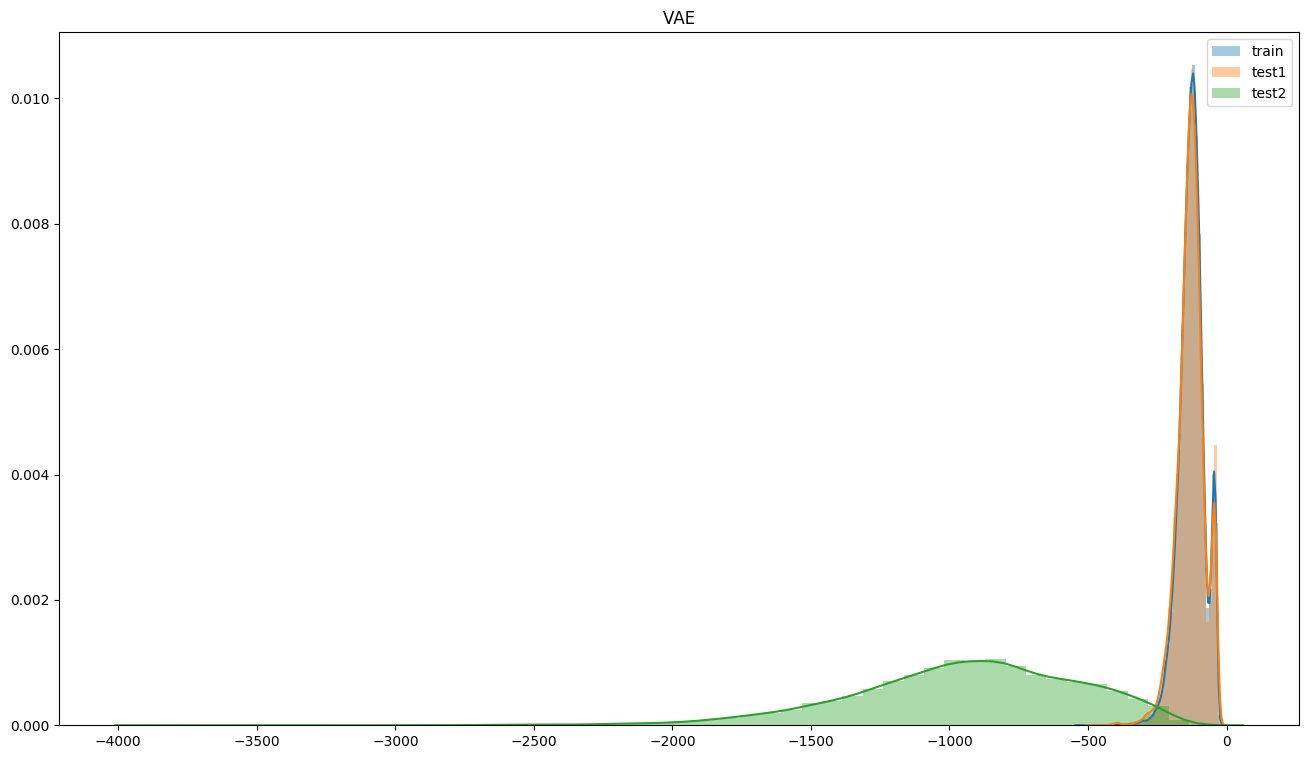

In [138]:
fig, ax1 = plt.subplots(1, 1, figsize=(16, 9))
seaborn.distplot(vae_elbo_train, ax=ax1, label='train')
seaborn.distplot(vae_elbo_test1, ax=ax1, label='test1')
seaborn.distplot(vae_elbo_test2, ax=ax1, label='test2')
ax1.set_title('VAE')
ax1.legend()

In [ ]:
avae_elbo_train, avae_kl_train, avae_likelihood_train = compute_elbo(avae, x_train, importance_samples=10)
avae_elbo_test1, avae_kl_test1, avae_likelihood_test1 = compute_elbo(avae, x_test1, importance_samples=10)
avae_elbo_test2, avae_kl_test2, avae_likelihood_test2 = compute_elbo(avae, x_test2, importance_samples=10)

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize=(16, 9))
seaborn.distplot(avae_elbo_train, ax=ax1, label='train')
seaborn.distplot(avae_elbo_test1, ax=ax1, label='test1')
seaborn.distplot(avae_elbo_test2, ax=ax1, label='test2')
ax1.set_title('AVAE')
ax1.legend()

In [139]:
hvae_elbo_train, hvae_kl_train, hvae_likelihood_train = compute_elbo(hvae, x_train, importance_samples=10)
hvae_elbo_test1, hvae_kl_test1, hvae_likelihood_test1 = compute_elbo(hvae, x_test1, importance_samples=10)
hvae_elbo_test2, hvae_kl_test2, hvae_likelihood_test2 = compute_elbo(hvae, x_test2, importance_samples=10)

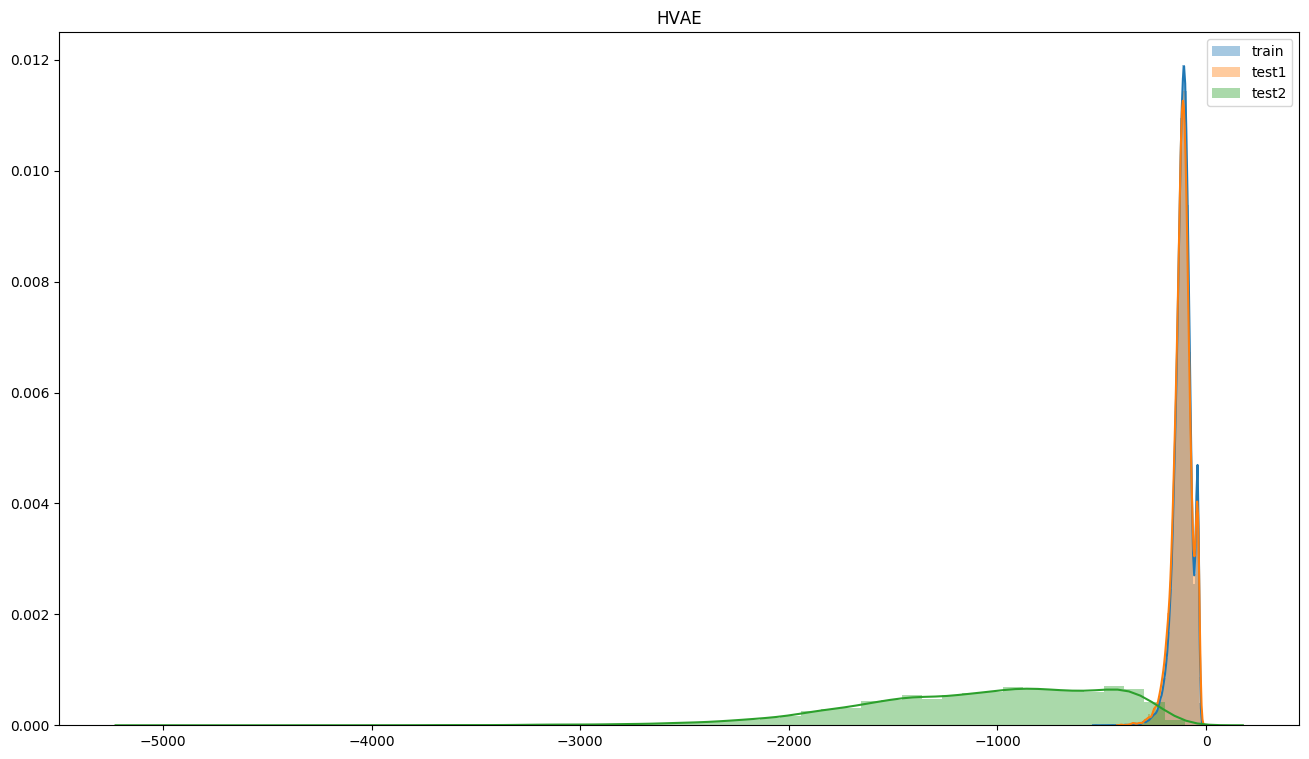

In [140]:
fig, ax1 = plt.subplots(1, 1, figsize=(16, 9))
seaborn.distplot(hvae_elbo_train, ax=ax1, label='train')
seaborn.distplot(hvae_elbo_test1, ax=ax1, label='test1')
seaborn.distplot(hvae_elbo_test2, ax=ax1, label='test2')
ax1.set_title('HVAE')
ax1.legend()

### OOD between classes

In [ ]:
run_ids_excluded_labels = dict(
    MNIST=dict(
        vae={'4': None, '8': None},
        hvae={'4': None, '8': None},
        avae={'4': None, '8': None}
    ),
    FashionMNIST=dict(
        vae={'4': None, '8': None},
        hvae={'4': None, '8': None},
        avae={'4': None, '8': None}
    )
)

In [13]:
def get_model_name_from_abbr(abbr):
    if abbr == 'vae':
        return 'VariationalAutoencoder'
    elif abbr == 'avae':
        return 'AuxilliaryVariationalAutoencoder'
    elif abbr == 'hvae':
        return 'HierarchicalVariationalAutoencoder'
    else:
        raise ValueError(abbr)

In [ ]:
ood_models = dict()
for dataset, models in run_ids_excluded_labels.items():
    ood_models[dataset] = dict()
    
    for model, exclusions in models.items():
        ood_models[dataset][model] = dict()
        
            for excluded_label, run_id in exclusions.items():
                model_name = get_model_name_from_abbr(model)
                kwargs = vari.models.get_default_model_config(model_name, dataset)
                model = getattr(vari.models.vae, model_name)
                model = model(x_dim=784, **kwargs)
                model.load_state_dict(torch.load(
                    os.path.join(experiments_dir, run_id, 'model_state_dict.pkl'),
                    map_location=torch.device('cpu')
                ))
                ood_models[dataset][model][excluded_label] = model

In [4]:
mnist_train = vari.datasets.MNISTBinarized(split='train', preprocess='static', exclude_labels=[], root=data_root)
mnist_test1 = vari.datasets.MNISTBinarized(split='test', preprocess='static', exclude_labels=[], root=data_root)

In [ ]:
fashion_mnist_train = vari.datasets.FashionMNISTBinarized(split='train', preprocess='static', exclude_labels=[], root=data_root)
fashion_mnist_test1 = vari.datasets.FashionMNISTBinarized(split='test', preprocess='static', exclude_labels=[], root=data_root)